In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import h5py 
import datetime

# Root directory of the project
path = '/mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN'
ROOT_DIR = os.path.abspath(path)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs_new")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [76]:
print('ROOT_DIR:',ROOT_DIR)
print('MODEL_DIR:',MODEL_DIR)
print('COCO_MODEL_PATH:',COCO_MODEL_PATH)

ROOT_DIR: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN
MODEL_DIR: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new
COCO_MODEL_PATH: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/mask_rcnn_coco.h5


In [3]:
train_path = '/mnt/sh_flex_storage/project/xcos_mask/data/trainset.h5'
test_path = '/mnt/sh_flex_storage/project/xcos_mask/data/testset.h5'
train_set = h5py.File(train_path,'r')
test_set = h5py.File(test_path,'r')

train_images = train_set['input']
test_images = test_set['input']
train_masks = train_set['output']
test_masks = test_set['output']

del train_set
del test_set
NUM_TRAIN = train_images.shape[0] # 224*224
NUM_TEST = test_images.shape[0]

In [4]:
class ChipsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "chips"
    
    #CH
    BACKBONE = "resnet50"
    MINI_MASK_SHAPE = (28,28)
    DETECTION_MAX_INSTANCES = 100
    ROI_POSITIVE_RATIO = 0.16
    USE_MINI_MASK = True
    
    # TRY CH
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1 # CH
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = NUM_TRAIN // IMAGES_PER_GPU
    VALIDATION_STEPS = 20


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels # CH

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 16 # CH 
    
   
    
config = ChipsConfig()
config.display()

'''
not apply in network yet
ROI_POSITIVE_RATIO = 0.33 # before 0.16
STEPS_PER_EPOCH = 200
'''


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

'\nnot apply in network yet\nROI_POSITIVE_RATIO = 0.33 # before 0.16\nSTEPS_PER_EPOCH = 200\n'

In [5]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class ChipsDataset(utils.Dataset):
    def __init__(self, class_map=None):
        #new_append 
        self.num_null_mask = 0
        self.all_flaw_size = []
        self.subset = ""
        #original
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def load_chips(self, count,subset):
        assert subset in ["train","test"]
        
        self.subset = subset
        
        # Add classes
        self.add_class("chips", 1, "bump")
        self.add_class("chips", 2, "dent")
        self.add_class("chips", 3, "dot")

        # Add images
        # Images are generated on the fly in load_image().
        for i in range(count):
            chips = self.mask_prepare(i)
            self.add_image("chips", image_id=i, path=None,chips=chips)
            
    
    def mask_prepare(self,i,return_mask=False):
        if self.subset == "train":
            mask_full = train_masks[i,:].reshape((4,224,224))
        else :
            mask_full = test_masks[i,:].reshape((4,224,224))
        
        bump,dent,dot = mask_full[1,:,:],mask_full[2,:,:],mask_full[3,:,:]   
        flaw_size = [np.sum(bump),np.sum(dent),np.sum(dot)]
        names = ["bump","dent","dot"]

        if not np.sum(flaw_size):
            self.num_null_mask += 1
            #print("==== no flaw for image %d ===="%i)

        if not return_mask:
            chips= []
            for j in range(3):
                if flaw_size[j] >0:
                    chips.append(names[j])
                    self.all_flaw_size.append(flaw_size[j])
            return chips
        else:
            masks = []
            for j in range(3):
                if flaw_size[j] >0:
                    masks.append(mask_full[j+1,:,:])
            if not np.array(masks).shape[0]:
                return np.array(masks)
            else:
                masks = np.array(masks)
                masks = masks.reshape((-1,224,224))
                masks_reshape = np.zeros((224,224,masks.shape[0]))
                #assert masks.shape[1:] in [(224,224)]
                for i in range(224):
                    for j in range(224):
                        masks_reshape[i,j,:] = masks[:,i,j]  
                return masks_reshape
                      
        
    def load_image(self,image_id):
        info = self.image_info[image_id]
        
        #print("check load_image image_id: ",image_id)
        
        if self.subset == "train":
            image_full = train_images[image_id,:].reshape((6,224,224))
        else:
            image_full = test_images[image_id,:].reshape((6,224,224))
            
        image_sel = np.array([image_full[0,:,:],image_full[1,:,:],image_full[2,:,:]])
        image_sel_reshape = np.zeros((224,224,3))
        for i in range(224):
            for j in range(224):
                image_sel_reshape[i,j,:] = image_sel[:,i,j]  
        image = image_sel_reshape
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "chips":
            return info["chips"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        chips = info['chips']
        mask = self.mask_prepare(image_id,True)
        
        class_ids = np.array([self.class_names.index(s) for s in chips])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def info_display(self,count):
        #flaw_size info
        max_flaw_size = np.max(self.all_flaw_size)
        min_flaw_size = np.min(self.all_flaw_size)
        mean_flaw_size = np.mean(self.all_flaw_size)
        
        #flaw_kind_info
        bump_num,dent_num,dot_num = 0,0,0
        for i in range(count):
            chips = self.image_info[i]['chips']
            if "bump" in chips:
                bump_num +=1
            if "dent" in chips:
                dent_num +=1
            if "dot" in chips:
                dot_num += 1    
                
        #display all info
        print("**** info of %s dataset : ***  "%self.subset)
        print("  ratio of null mask images:%d %%"%(self.num_null_mask/count*100))
        print("  max flaw size:",max_flaw_size)
        print("  min flaw size:",min_flaw_size)
        print("  mean flaw size:",mean_flaw_size)
        print("  bump ratio:%d %%"%(bump_num/count*100))
        print("  dent ratio:%d %%"%(dent_num/count*100))
        print("  dot ratio:%d %%"%(dot_num/count*100))
        

In [7]:
# Testing dataset
dataset_test = ChipsDataset()
dataset_test.load_chips(NUM_TEST,"test")
dataset_test.prepare()
dataset_test.info_display(NUM_TEST)

**** info of test dataset : ***  
  ratio of null mask images:21 %
  max flaw size: 96
  min flaw size: 2
  mean flaw size: 29.385158254918736
  bump ratio:23 %
  dent ratio:32 %
  dot ratio:23 %


In [8]:
#Traning dataset
#cost several mins 
dataset_train = ChipsDataset()
dataset_train.load_chips(NUM_TRAIN,"train")
dataset_train.prepare()
dataset_train.info_display(NUM_TRAIN)

**** info of train dataset : ***  
  ratio of null mask images:22 %
  max flaw size: 102
  min flaw size: 2
  mean flaw size: 29.65715769880092
  bump ratio:22 %
  dent ratio:33 %
  dot ratio:22 %


## Ceate Model

In [85]:
# Create model in training mode
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [86]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model_path = "/mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/mask_rcnn_chips_0815.h5"
    # Load the last model you trained and continue training
    model.load_weights(model_path, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [87]:
start = time.time()
# use_multiprocessing=False
import warnings
warnings.filterwarnings('ignore')
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='all')
print("time consuming:",time.time()-start)


Starting at epoch 0. LR=0.001

Checkpoint Path: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/chips20180903T1322/mask_rcnn_chips_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

In [89]:
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE,
            epochs=5, 
            layers="heads")


Starting at epoch 3. LR=0.001

Checkpoint Path: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/chips20180903T1322/mask_rcnn_chips_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

In [90]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_chips_0904_rpn_match.h5")
model.keras_model.save_weights(model_path)

## Detection

In [73]:
class InferenceConfig(ChipsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# MODEL_DIR = os.path.join(ROOT_DIR, "logs_chips3")
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_chips_3_090417.h5")
model_path = 'venv/CHIPS_MRCNN/logs_chips3/chips20180905T1559/mask_rcnn_chips_0005.h5'
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir= MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_chips.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_chips3/mask_rcnn_chips_3_090417.h5


original_image           shape: (256, 256, 3)         min:   17.61328  max:  252.88672  float64
image_meta               shape: (16,)                 min:    0.00000  max: 1955.00000  float64
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:   23.00000  max:  136.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


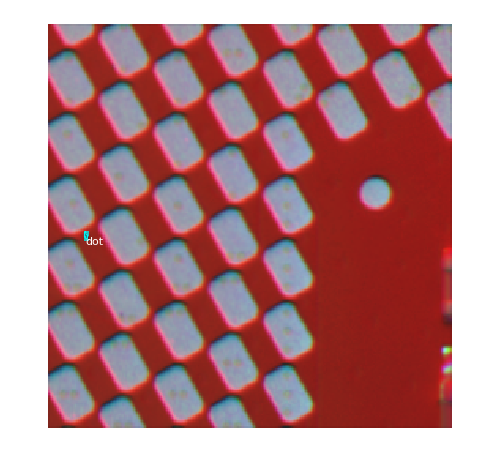

In [74]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8),colors=[(0.0, 1.0, 1.0)])

Processing 1 images
image                    shape: (256, 256, 3)         min:   17.61328  max:  252.88672  float64
molded_images            shape: (1, 256, 256, 3)      min:  -99.18672  max:  136.08672  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


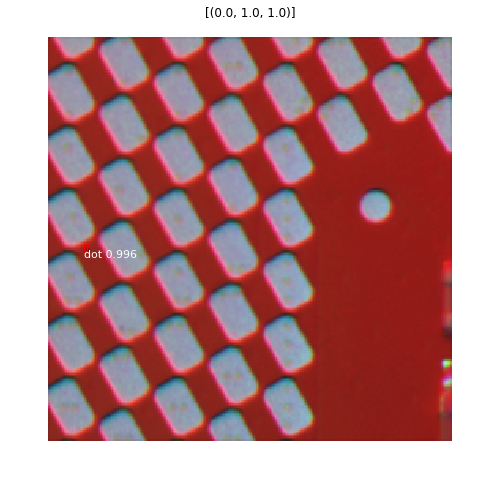

In [75]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], [(0.0, 1.0, 1.0)],ax=get_ax())

In [102]:
r['scores']

array([0.9960867], dtype=float32)

## Evaluation on test (5939 images)
### after 2 epoch on all layers 
- mAP:  1.0(iou = 0.3)
- precision: 0.9087388449233877
- percent of wrong pre on good chips = 20%
- percent of wrong pre when class = 0 41%
- percent of wrong pre when class = 1 14%
- percent of wrong pre when class = 2 18%
- percent of wrong pre when class = 3 25%
### after 2+3 epoch on all layers
- mAP: 0.7459448840994556(0.5)
- precision:0.93
- percent of wrong pre on good chips = 16% 
- false_positive/total = 3%
- false_negative/toal = 1%
- false_positive/false = 47%
- false_negative/false = 23%
### after 5 more epoch on all layers(rpn_match modified)
- mAP =  0.7742324746029073
- precision =  94%
- false_positive/total = 3%
- false_negative/toal = 0%
- false_positive/negative = 18%
- false_negative/positive = 0%

In [104]:
import pandas as pd
import time 

def model_eval(dataset,name):
    start = time.time()
    if name == 'train':
        image_ids = dataset.image_ids
    else:
        image_ids = dataset.image_ids
        
    gt_class = []
    pre_class = []
    ap = []
    score = []
    
    for image_id in image_ids:
        print('working on %d'%image_id)
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                   image_id, use_mini_mask=False)
        # molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]

        # Compute AP
        if len(r['class_ids'])>0 and len(gt_class_id)>0 :
            AP, precisions, recalls, overlaps =utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                 r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=0.5)
            #print(AP)
            ap.append(AP)
        else:
            ap.append(0)

        if not len(r['class_ids']) :
            pre_class.append(0)
            score.append(0)
        else:
            pre_class.append(r['class_ids'][0])
            score.append(r['scores'][0])

        if not len(gt_class_id):
            gt_class.append(0)
        else:
            gt_class.append(gt_class_id[0])
    
   
    # predict summary
    result = pd.DataFrame()
    result['image_id'] = image_ids
    result['gt_class'] = gt_class
    result['pre_class'] = pre_class
    result['ap'] = ap
    result['score']=score
    
    return result 

def info_display(result):
    
    image_ids = result['image_id']
    gt_class = result['gt_class']
    pre_class = result['pre_class']
    ap = result['ap']
    
    #result display
    diff = np.array(gt_class)-np.array(pre_class)
    diff = diff.tolist()
    precision = diff.count(0)/len(diff)
    total_false = len(diff)-diff.count(0)
    
    negative = len(result[result['gt_class']==0])
    positive = len(result)-negative
    
    false_positive = len(result[result['gt_class']==0][result['pre_class']!=0])
    false_negative = len(result[result['gt_class']!=0][result['pre_class']==0])
    
    #print('evaluation on %s'%name)
    print('mAP = ',np.mean(ap))
    print('precision =  %d%%'%(precision*100))
    print('false_positive/total = %d%%'%(false_positive/len(image_ids)*100))
    print('false_negative/toal = %d%%'%(false_negative/len(image_ids)*100))
  
    print('false_positive/negative = %d%%'%((false_positive/negative)*100))
    print('false_negative/positive = %d%%'%((false_negative/positive)*100))
    
    print('time consuming:',time.time()-start)

In [80]:
# image_ids = np.random.choice(dataset_test.image_ids, 100)
import warnings 
warnings.filterwarnings('ignore')
test_result = model_eval(dataset_test,'test')

working on 0
working on 1
working on 2
working on 3
working on 4
working on 5
working on 6
working on 7
working on 8
working on 9
working on 10
working on 11
working on 12
working on 13
working on 14
working on 15
working on 16
working on 17
working on 18
working on 19
working on 20
working on 21
working on 22
working on 23
working on 24
working on 25
working on 26
working on 27
working on 28
working on 29
working on 30
working on 31
working on 32
working on 33
working on 34
working on 35
working on 36
working on 37
working on 38
working on 39
working on 40
working on 41
working on 42
working on 43
working on 44
working on 45
working on 46
working on 47
working on 48
working on 49
working on 50
working on 51
working on 52
working on 53
working on 54
working on 55
working on 56
working on 57
working on 58
working on 59
working on 60
working on 61
working on 62
working on 63
working on 64
working on 65
working on 66
working on 67
working on 68
working on 69
working on 70
working on 71
wo

working on 554
working on 555
working on 556
working on 557
working on 558
working on 559
working on 560
working on 561
working on 562
working on 563
working on 564
working on 565
working on 566
working on 567
working on 568
working on 569
working on 570
working on 571
working on 572
working on 573
working on 574
working on 575
working on 576
working on 577
working on 578
working on 579
working on 580
working on 581
working on 582
working on 583
working on 584
working on 585
working on 586
working on 587
working on 588
working on 589
working on 590
working on 591
working on 592
working on 593
working on 594
working on 595
working on 596
working on 597
working on 598
working on 599
working on 600
working on 601
working on 602
working on 603
working on 604
working on 605
working on 606
working on 607
working on 608
working on 609
working on 610
working on 611
working on 612
working on 613
working on 614
working on 615
working on 616
working on 617
working on 618
working on 619
working on

working on 1094
working on 1095
working on 1096
working on 1097
working on 1098
working on 1099
working on 1100
working on 1101
working on 1102
working on 1103
working on 1104
working on 1105
working on 1106
working on 1107
working on 1108
working on 1109
working on 1110
working on 1111
working on 1112
working on 1113
working on 1114
working on 1115
working on 1116
working on 1117
working on 1118
working on 1119
working on 1120
working on 1121
working on 1122
working on 1123
working on 1124
working on 1125
working on 1126
working on 1127
working on 1128
working on 1129
working on 1130
working on 1131
working on 1132
working on 1133
working on 1134
working on 1135
working on 1136
working on 1137
working on 1138
working on 1139
working on 1140
working on 1141
working on 1142
working on 1143
working on 1144
working on 1145
working on 1146
working on 1147
working on 1148
working on 1149
working on 1150
working on 1151
working on 1152
working on 1153
working on 1154
working on 1155
working 

working on 1607
working on 1608
working on 1609
working on 1610
working on 1611
working on 1612
working on 1613
working on 1614
working on 1615
working on 1616
working on 1617
working on 1618
working on 1619
working on 1620
working on 1621
working on 1622
working on 1623
working on 1624
working on 1625
working on 1626
working on 1627
working on 1628
working on 1629
working on 1630
working on 1631
working on 1632
working on 1633
working on 1634
working on 1635
working on 1636
working on 1637
working on 1638
working on 1639
working on 1640
working on 1641
working on 1642
working on 1643
working on 1644
working on 1645
working on 1646
working on 1647
working on 1648
working on 1649
working on 1650
working on 1651
working on 1652
working on 1653
working on 1654
working on 1655
working on 1656
working on 1657
working on 1658
working on 1659
working on 1660
working on 1661
working on 1662
working on 1663
working on 1664
working on 1665
working on 1666
working on 1667
working on 1668
working 

working on 2120
working on 2121
working on 2122
working on 2123
working on 2124
working on 2125
working on 2126
working on 2127
working on 2128
working on 2129
working on 2130
working on 2131
working on 2132
working on 2133
working on 2134
working on 2135
working on 2136
working on 2137
working on 2138
working on 2139
working on 2140
working on 2141
working on 2142
working on 2143
working on 2144
working on 2145
working on 2146
working on 2147
working on 2148
working on 2149
working on 2150
working on 2151
working on 2152
working on 2153
working on 2154
working on 2155
working on 2156
working on 2157
working on 2158
working on 2159
working on 2160
working on 2161
working on 2162
working on 2163
working on 2164
working on 2165
working on 2166
working on 2167
working on 2168
working on 2169
working on 2170
working on 2171
working on 2172
working on 2173
working on 2174
working on 2175
working on 2176
working on 2177
working on 2178
working on 2179
working on 2180
working on 2181
working 

working on 2633
working on 2634
working on 2635
working on 2636
working on 2637
working on 2638
working on 2639
working on 2640
working on 2641
working on 2642
working on 2643
working on 2644
working on 2645
working on 2646
working on 2647
working on 2648
working on 2649
working on 2650
working on 2651
working on 2652
working on 2653
working on 2654
working on 2655
working on 2656
working on 2657
working on 2658
working on 2659
working on 2660
working on 2661
working on 2662
working on 2663
working on 2664
working on 2665
working on 2666
working on 2667
working on 2668
working on 2669
working on 2670
working on 2671
working on 2672
working on 2673
working on 2674
working on 2675
working on 2676
working on 2677
working on 2678
working on 2679
working on 2680
working on 2681
working on 2682
working on 2683
working on 2684
working on 2685
working on 2686
working on 2687
working on 2688
working on 2689
working on 2690
working on 2691
working on 2692
working on 2693
working on 2694
working 

working on 3146
working on 3147
working on 3148
working on 3149
working on 3150
working on 3151
working on 3152
working on 3153
working on 3154
working on 3155
working on 3156
working on 3157
working on 3158
working on 3159
working on 3160
working on 3161
working on 3162
working on 3163
working on 3164
working on 3165
working on 3166
working on 3167
working on 3168
working on 3169
working on 3170
working on 3171
working on 3172
working on 3173
working on 3174
working on 3175
working on 3176
working on 3177
working on 3178
working on 3179
working on 3180
working on 3181
working on 3182
working on 3183
working on 3184
working on 3185
working on 3186
working on 3187
working on 3188
working on 3189
working on 3190
working on 3191
working on 3192
working on 3193
working on 3194
working on 3195
working on 3196
working on 3197
working on 3198
working on 3199
working on 3200
working on 3201
working on 3202
working on 3203
working on 3204
working on 3205
working on 3206
working on 3207
working 

working on 3659
working on 3660
working on 3661
working on 3662
working on 3663
working on 3664
working on 3665
working on 3666
working on 3667
working on 3668
working on 3669
working on 3670
working on 3671
working on 3672
working on 3673
working on 3674
working on 3675
working on 3676
working on 3677
working on 3678
working on 3679
working on 3680
working on 3681
working on 3682
working on 3683
working on 3684
working on 3685
working on 3686
working on 3687
working on 3688
working on 3689
working on 3690
working on 3691
working on 3692
working on 3693
working on 3694
working on 3695
working on 3696
working on 3697
working on 3698
working on 3699
working on 3700
working on 3701
working on 3702
working on 3703
working on 3704
working on 3705
working on 3706
working on 3707
working on 3708
working on 3709
working on 3710
working on 3711
working on 3712
working on 3713
working on 3714
working on 3715
working on 3716
working on 3717
working on 3718
working on 3719
working on 3720
working 

working on 4172
working on 4173
working on 4174
working on 4175
working on 4176
working on 4177
working on 4178
working on 4179
working on 4180
working on 4181
working on 4182
working on 4183
working on 4184
working on 4185
working on 4186
working on 4187
working on 4188
working on 4189
working on 4190
working on 4191
working on 4192
working on 4193
working on 4194
working on 4195
working on 4196
working on 4197
working on 4198
working on 4199
working on 4200
working on 4201
working on 4202
working on 4203
working on 4204
working on 4205
working on 4206
working on 4207
working on 4208
working on 4209
working on 4210
working on 4211
working on 4212
working on 4213
working on 4214
working on 4215
working on 4216
working on 4217
working on 4218
working on 4219
working on 4220
working on 4221
working on 4222
working on 4223
working on 4224
working on 4225
working on 4226
working on 4227
working on 4228
working on 4229
working on 4230
working on 4231
working on 4232
working on 4233
working 

working on 4685
working on 4686
working on 4687
working on 4688
working on 4689
working on 4690
working on 4691
working on 4692
working on 4693
working on 4694
working on 4695
working on 4696
working on 4697
working on 4698
working on 4699
working on 4700
working on 4701
working on 4702
working on 4703
working on 4704
working on 4705
working on 4706
working on 4707
working on 4708
working on 4709
working on 4710
working on 4711
working on 4712
working on 4713
working on 4714
working on 4715
working on 4716
working on 4717
working on 4718
working on 4719
working on 4720
working on 4721
working on 4722
working on 4723
working on 4724
working on 4725
working on 4726
working on 4727
working on 4728
working on 4729
working on 4730
working on 4731
working on 4732
working on 4733
working on 4734
working on 4735
working on 4736
working on 4737
working on 4738
working on 4739
working on 4740
working on 4741
working on 4742
working on 4743
working on 4744
working on 4745
working on 4746
working 

working on 5198
working on 5199
working on 5200
working on 5201
working on 5202
working on 5203
working on 5204
working on 5205
working on 5206
working on 5207
working on 5208
working on 5209
working on 5210
working on 5211
working on 5212
working on 5213
working on 5214
working on 5215
working on 5216
working on 5217
working on 5218
working on 5219
working on 5220
working on 5221
working on 5222
working on 5223
working on 5224
working on 5225
working on 5226
working on 5227
working on 5228
working on 5229
working on 5230
working on 5231
working on 5232
working on 5233
working on 5234
working on 5235
working on 5236
working on 5237
working on 5238
working on 5239
working on 5240
working on 5241
working on 5242
working on 5243
working on 5244
working on 5245
working on 5246
working on 5247
working on 5248
working on 5249
working on 5250
working on 5251
working on 5252
working on 5253
working on 5254
working on 5255
working on 5256
working on 5257
working on 5258
working on 5259
working 

working on 5711
working on 5712
working on 5713
working on 5714
working on 5715
working on 5716
working on 5717
working on 5718
working on 5719
working on 5720
working on 5721
working on 5722
working on 5723
working on 5724
working on 5725
working on 5726
working on 5727
working on 5728
working on 5729
working on 5730
working on 5731
working on 5732
working on 5733
working on 5734
working on 5735
working on 5736
working on 5737
working on 5738
working on 5739
working on 5740
working on 5741
working on 5742
working on 5743
working on 5744
working on 5745
working on 5746
working on 5747
working on 5748
working on 5749
working on 5750
working on 5751
working on 5752
working on 5753
working on 5754
working on 5755
working on 5756
working on 5757
working on 5758
working on 5759
working on 5760
working on 5761
working on 5762
working on 5763
working on 5764
working on 5765
working on 5766
working on 5767
working on 5768
working on 5769
working on 5770
working on 5771
working on 5772
working 

In [83]:
info_display(test_result)

mAP =  0.7742324746029073
precision =  94%
false_positive/total = 3%
false_negative/toal = 0%
false_positive/negative = 18%
false_negative/positive = 0%
time consuming: 96507.53729462624


In [105]:
train_result = model_eval(dataset_train,'train')

working on 0
working on 1
working on 2
working on 3
working on 4
working on 5
working on 6
working on 7
working on 8
working on 9
working on 10
working on 11
working on 12
working on 13
working on 14
working on 15
working on 16
working on 17
working on 18
working on 19
working on 20
working on 21
working on 22
working on 23
working on 24
working on 25
working on 26
working on 27
working on 28
working on 29
working on 30
working on 31
working on 32
working on 33
working on 34
working on 35
working on 36
working on 37
working on 38
working on 39
working on 40
working on 41
working on 42
working on 43
working on 44
working on 45
working on 46
working on 47
working on 48
working on 49
working on 50
working on 51
working on 52
working on 53
working on 54
working on 55
working on 56
working on 57
working on 58
working on 59
working on 60
working on 61
working on 62
working on 63
working on 64
working on 65
working on 66
working on 67
working on 68
working on 69
working on 70
working on 71
wo

working on 554
working on 555
working on 556
working on 557
working on 558
working on 559
working on 560
working on 561
working on 562
working on 563
working on 564
working on 565
working on 566
working on 567
working on 568
working on 569
working on 570
working on 571
working on 572
working on 573
working on 574
working on 575
working on 576
working on 577
working on 578
working on 579
working on 580
working on 581
working on 582
working on 583
working on 584
working on 585
working on 586
working on 587
working on 588
working on 589
working on 590
working on 591
working on 592
working on 593
working on 594
working on 595
working on 596
working on 597
working on 598
working on 599
working on 600
working on 601
working on 602
working on 603
working on 604
working on 605
working on 606
working on 607
working on 608
working on 609
working on 610
working on 611
working on 612
working on 613
working on 614
working on 615
working on 616
working on 617
working on 618
working on 619
working on

working on 1094
working on 1095
working on 1096
working on 1097
working on 1098
working on 1099
working on 1100
working on 1101
working on 1102
working on 1103
working on 1104
working on 1105
working on 1106
working on 1107
working on 1108
working on 1109
working on 1110
working on 1111
working on 1112
working on 1113
working on 1114
working on 1115
working on 1116
working on 1117
working on 1118
working on 1119
working on 1120
working on 1121
working on 1122
working on 1123
working on 1124
working on 1125
working on 1126
working on 1127
working on 1128
working on 1129
working on 1130
working on 1131
working on 1132
working on 1133
working on 1134
working on 1135
working on 1136
working on 1137
working on 1138
working on 1139
working on 1140
working on 1141
working on 1142
working on 1143
working on 1144
working on 1145
working on 1146
working on 1147
working on 1148
working on 1149
working on 1150
working on 1151
working on 1152
working on 1153
working on 1154
working on 1155
working 

working on 1607
working on 1608
working on 1609
working on 1610
working on 1611
working on 1612
working on 1613
working on 1614
working on 1615
working on 1616
working on 1617
working on 1618
working on 1619
working on 1620
working on 1621
working on 1622
working on 1623
working on 1624
working on 1625
working on 1626
working on 1627
working on 1628
working on 1629
working on 1630
working on 1631
working on 1632
working on 1633
working on 1634
working on 1635
working on 1636
working on 1637
working on 1638
working on 1639
working on 1640
working on 1641
working on 1642
working on 1643
working on 1644
working on 1645
working on 1646
working on 1647
working on 1648
working on 1649
working on 1650
working on 1651
working on 1652
working on 1653
working on 1654
working on 1655
working on 1656
working on 1657
working on 1658
working on 1659
working on 1660
working on 1661
working on 1662
working on 1663
working on 1664
working on 1665
working on 1666
working on 1667
working on 1668
working 

working on 2120
working on 2121
working on 2122
working on 2123
working on 2124
working on 2125
working on 2126
working on 2127
working on 2128
working on 2129
working on 2130
working on 2131
working on 2132
working on 2133
working on 2134
working on 2135
working on 2136
working on 2137
working on 2138
working on 2139
working on 2140
working on 2141
working on 2142
working on 2143
working on 2144
working on 2145
working on 2146
working on 2147
working on 2148
working on 2149
working on 2150
working on 2151
working on 2152
working on 2153
working on 2154
working on 2155
working on 2156
working on 2157
working on 2158
working on 2159
working on 2160
working on 2161
working on 2162
working on 2163
working on 2164
working on 2165
working on 2166
working on 2167
working on 2168
working on 2169
working on 2170
working on 2171
working on 2172
working on 2173
working on 2174
working on 2175
working on 2176
working on 2177
working on 2178
working on 2179
working on 2180
working on 2181
working 

working on 2633
working on 2634
working on 2635
working on 2636
working on 2637
working on 2638
working on 2639
working on 2640
working on 2641
working on 2642
working on 2643
working on 2644
working on 2645
working on 2646
working on 2647
working on 2648
working on 2649
working on 2650
working on 2651
working on 2652
working on 2653
working on 2654
working on 2655
working on 2656
working on 2657
working on 2658
working on 2659
working on 2660
working on 2661
working on 2662
working on 2663
working on 2664
working on 2665
working on 2666
working on 2667
working on 2668
working on 2669
working on 2670
working on 2671
working on 2672
working on 2673
working on 2674
working on 2675
working on 2676
working on 2677
working on 2678
working on 2679
working on 2680
working on 2681
working on 2682
working on 2683
working on 2684
working on 2685
working on 2686
working on 2687
working on 2688
working on 2689
working on 2690
working on 2691
working on 2692
working on 2693
working on 2694
working 

working on 3146
working on 3147
working on 3148
working on 3149
working on 3150
working on 3151
working on 3152
working on 3153
working on 3154
working on 3155
working on 3156
working on 3157
working on 3158
working on 3159
working on 3160
working on 3161
working on 3162
working on 3163
working on 3164
working on 3165
working on 3166
working on 3167
working on 3168
working on 3169
working on 3170
working on 3171
working on 3172
working on 3173
working on 3174
working on 3175
working on 3176
working on 3177
working on 3178
working on 3179
working on 3180
working on 3181
working on 3182
working on 3183
working on 3184
working on 3185
working on 3186
working on 3187
working on 3188
working on 3189
working on 3190
working on 3191
working on 3192
working on 3193
working on 3194
working on 3195
working on 3196
working on 3197
working on 3198
working on 3199
working on 3200
working on 3201
working on 3202
working on 3203
working on 3204
working on 3205
working on 3206
working on 3207
working 

working on 3659
working on 3660
working on 3661
working on 3662
working on 3663
working on 3664
working on 3665
working on 3666
working on 3667
working on 3668
working on 3669
working on 3670
working on 3671
working on 3672
working on 3673
working on 3674
working on 3675
working on 3676
working on 3677
working on 3678
working on 3679
working on 3680
working on 3681
working on 3682
working on 3683
working on 3684
working on 3685
working on 3686
working on 3687
working on 3688
working on 3689
working on 3690
working on 3691
working on 3692
working on 3693
working on 3694
working on 3695
working on 3696
working on 3697
working on 3698
working on 3699
working on 3700
working on 3701
working on 3702
working on 3703
working on 3704
working on 3705
working on 3706
working on 3707
working on 3708
working on 3709
working on 3710
working on 3711
working on 3712
working on 3713
working on 3714
working on 3715
working on 3716
working on 3717
working on 3718
working on 3719
working on 3720
working 

working on 4172
working on 4173
working on 4174
working on 4175
working on 4176
working on 4177
working on 4178
working on 4179
working on 4180
working on 4181
working on 4182
working on 4183
working on 4184
working on 4185
working on 4186
working on 4187
working on 4188
working on 4189
working on 4190
working on 4191
working on 4192
working on 4193
working on 4194
working on 4195
working on 4196
working on 4197
working on 4198
working on 4199
working on 4200
working on 4201
working on 4202
working on 4203
working on 4204
working on 4205
working on 4206
working on 4207
working on 4208
working on 4209
working on 4210
working on 4211
working on 4212
working on 4213
working on 4214
working on 4215
working on 4216
working on 4217
working on 4218
working on 4219
working on 4220
working on 4221
working on 4222
working on 4223
working on 4224
working on 4225
working on 4226
working on 4227
working on 4228
working on 4229
working on 4230
working on 4231
working on 4232
working on 4233
working 

working on 4685
working on 4686
working on 4687
working on 4688
working on 4689
working on 4690
working on 4691
working on 4692
working on 4693
working on 4694
working on 4695
working on 4696
working on 4697
working on 4698
working on 4699
working on 4700
working on 4701
working on 4702
working on 4703
working on 4704
working on 4705
working on 4706
working on 4707
working on 4708
working on 4709
working on 4710
working on 4711
working on 4712
working on 4713
working on 4714
working on 4715
working on 4716
working on 4717
working on 4718
working on 4719
working on 4720
working on 4721
working on 4722
working on 4723
working on 4724
working on 4725
working on 4726
working on 4727
working on 4728
working on 4729
working on 4730
working on 4731
working on 4732
working on 4733
working on 4734
working on 4735
working on 4736
working on 4737
working on 4738
working on 4739
working on 4740
working on 4741
working on 4742
working on 4743
working on 4744
working on 4745
working on 4746
working 

working on 5198
working on 5199
working on 5200
working on 5201
working on 5202
working on 5203
working on 5204
working on 5205
working on 5206
working on 5207
working on 5208
working on 5209
working on 5210
working on 5211
working on 5212
working on 5213
working on 5214
working on 5215
working on 5216
working on 5217
working on 5218
working on 5219
working on 5220
working on 5221
working on 5222
working on 5223
working on 5224
working on 5225
working on 5226
working on 5227
working on 5228
working on 5229
working on 5230
working on 5231
working on 5232
working on 5233
working on 5234
working on 5235
working on 5236
working on 5237
working on 5238
working on 5239
working on 5240
working on 5241
working on 5242
working on 5243
working on 5244
working on 5245
working on 5246
working on 5247
working on 5248
working on 5249
working on 5250
working on 5251
working on 5252
working on 5253
working on 5254
working on 5255
working on 5256
working on 5257
working on 5258
working on 5259
working 

working on 5711
working on 5712
working on 5713
working on 5714
working on 5715
working on 5716
working on 5717
working on 5718
working on 5719
working on 5720
working on 5721
working on 5722
working on 5723
working on 5724
working on 5725
working on 5726
working on 5727
working on 5728
working on 5729
working on 5730
working on 5731
working on 5732
working on 5733
working on 5734
working on 5735
working on 5736
working on 5737
working on 5738
working on 5739
working on 5740
working on 5741
working on 5742
working on 5743
working on 5744
working on 5745
working on 5746
working on 5747
working on 5748
working on 5749
working on 5750
working on 5751
working on 5752
working on 5753
working on 5754
working on 5755
working on 5756
working on 5757
working on 5758
working on 5759
working on 5760
working on 5761
working on 5762
working on 5763
working on 5764
working on 5765
working on 5766
working on 5767
working on 5768
working on 5769
working on 5770
working on 5771
working on 5772
working 

working on 6224
working on 6225
working on 6226
working on 6227
working on 6228
working on 6229
working on 6230
working on 6231
working on 6232
working on 6233
working on 6234
working on 6235
working on 6236
working on 6237
working on 6238
working on 6239
working on 6240
working on 6241
working on 6242
working on 6243
working on 6244
working on 6245
working on 6246
working on 6247
working on 6248
working on 6249
working on 6250
working on 6251
working on 6252
working on 6253
working on 6254
working on 6255
working on 6256
working on 6257
working on 6258
working on 6259
working on 6260
working on 6261
working on 6262
working on 6263
working on 6264
working on 6265
working on 6266
working on 6267
working on 6268
working on 6269
working on 6270
working on 6271
working on 6272
working on 6273
working on 6274
working on 6275
working on 6276
working on 6277
working on 6278
working on 6279
working on 6280
working on 6281
working on 6282
working on 6283
working on 6284
working on 6285
working 

working on 6737
working on 6738
working on 6739
working on 6740
working on 6741
working on 6742
working on 6743
working on 6744
working on 6745
working on 6746
working on 6747
working on 6748
working on 6749
working on 6750
working on 6751
working on 6752
working on 6753
working on 6754
working on 6755
working on 6756
working on 6757
working on 6758
working on 6759
working on 6760
working on 6761
working on 6762
working on 6763
working on 6764
working on 6765
working on 6766
working on 6767
working on 6768
working on 6769
working on 6770
working on 6771
working on 6772
working on 6773
working on 6774
working on 6775
working on 6776
working on 6777
working on 6778
working on 6779
working on 6780
working on 6781
working on 6782
working on 6783
working on 6784
working on 6785
working on 6786
working on 6787
working on 6788
working on 6789
working on 6790
working on 6791
working on 6792
working on 6793
working on 6794
working on 6795
working on 6796
working on 6797
working on 6798
working 

working on 7250
working on 7251
working on 7252
working on 7253
working on 7254
working on 7255
working on 7256
working on 7257
working on 7258
working on 7259
working on 7260
working on 7261
working on 7262
working on 7263
working on 7264
working on 7265
working on 7266
working on 7267
working on 7268
working on 7269
working on 7270
working on 7271
working on 7272
working on 7273
working on 7274
working on 7275
working on 7276
working on 7277
working on 7278
working on 7279
working on 7280
working on 7281
working on 7282
working on 7283
working on 7284
working on 7285
working on 7286
working on 7287
working on 7288
working on 7289
working on 7290
working on 7291
working on 7292
working on 7293
working on 7294
working on 7295
working on 7296
working on 7297
working on 7298
working on 7299
working on 7300
working on 7301
working on 7302
working on 7303
working on 7304
working on 7305
working on 7306
working on 7307
working on 7308
working on 7309
working on 7310
working on 7311
working 

working on 7763
working on 7764
working on 7765
working on 7766
working on 7767
working on 7768
working on 7769
working on 7770
working on 7771
working on 7772
working on 7773
working on 7774
working on 7775
working on 7776
working on 7777
working on 7778
working on 7779
working on 7780
working on 7781
working on 7782
working on 7783
working on 7784
working on 7785
working on 7786
working on 7787
working on 7788
working on 7789
working on 7790
working on 7791
working on 7792
working on 7793
working on 7794
working on 7795
working on 7796
working on 7797
working on 7798
working on 7799
working on 7800
working on 7801
working on 7802
working on 7803
working on 7804
working on 7805
working on 7806
working on 7807
working on 7808
working on 7809
working on 7810
working on 7811
working on 7812
working on 7813
working on 7814
working on 7815
working on 7816
working on 7817
working on 7818
working on 7819
working on 7820
working on 7821
working on 7822
working on 7823
working on 7824
working 

working on 8276
working on 8277
working on 8278
working on 8279
working on 8280
working on 8281
working on 8282
working on 8283
working on 8284
working on 8285
working on 8286
working on 8287
working on 8288
working on 8289
working on 8290
working on 8291
working on 8292
working on 8293
working on 8294
working on 8295
working on 8296
working on 8297
working on 8298
working on 8299
working on 8300
working on 8301
working on 8302
working on 8303
working on 8304
working on 8305
working on 8306
working on 8307
working on 8308
working on 8309
working on 8310
working on 8311
working on 8312
working on 8313
working on 8314
working on 8315
working on 8316
working on 8317
working on 8318
working on 8319
working on 8320
working on 8321
working on 8322
working on 8323
working on 8324
working on 8325
working on 8326
working on 8327
working on 8328
working on 8329
working on 8330
working on 8331
working on 8332
working on 8333
working on 8334
working on 8335
working on 8336
working on 8337
working 

working on 8789
working on 8790
working on 8791
working on 8792
working on 8793
working on 8794
working on 8795
working on 8796
working on 8797
working on 8798
working on 8799
working on 8800
working on 8801
working on 8802
working on 8803
working on 8804
working on 8805
working on 8806
working on 8807
working on 8808
working on 8809
working on 8810
working on 8811
working on 8812
working on 8813
working on 8814
working on 8815
working on 8816
working on 8817
working on 8818
working on 8819
working on 8820
working on 8821
working on 8822
working on 8823
working on 8824
working on 8825
working on 8826
working on 8827
working on 8828
working on 8829
working on 8830
working on 8831
working on 8832
working on 8833
working on 8834
working on 8835
working on 8836
working on 8837
working on 8838
working on 8839
working on 8840
working on 8841
working on 8842
working on 8843
working on 8844
working on 8845
working on 8846
working on 8847
working on 8848
working on 8849
working on 8850
working 

working on 9302
working on 9303
working on 9304
working on 9305
working on 9306
working on 9307
working on 9308
working on 9309
working on 9310
working on 9311
working on 9312
working on 9313
working on 9314
working on 9315
working on 9316
working on 9317
working on 9318
working on 9319
working on 9320
working on 9321
working on 9322
working on 9323
working on 9324
working on 9325
working on 9326
working on 9327
working on 9328
working on 9329
working on 9330
working on 9331
working on 9332
working on 9333
working on 9334
working on 9335
working on 9336
working on 9337
working on 9338
working on 9339
working on 9340
working on 9341
working on 9342
working on 9343
working on 9344
working on 9345
working on 9346
working on 9347
working on 9348
working on 9349
working on 9350
working on 9351
working on 9352
working on 9353
working on 9354
working on 9355
working on 9356
working on 9357
working on 9358
working on 9359
working on 9360
working on 9361
working on 9362
working on 9363
working 

working on 9815
working on 9816
working on 9817
working on 9818
working on 9819
working on 9820
working on 9821
working on 9822
working on 9823
working on 9824
working on 9825
working on 9826
working on 9827
working on 9828
working on 9829
working on 9830
working on 9831
working on 9832
working on 9833
working on 9834
working on 9835
working on 9836
working on 9837
working on 9838
working on 9839
working on 9840
working on 9841
working on 9842
working on 9843
working on 9844
working on 9845
working on 9846
working on 9847
working on 9848
working on 9849
working on 9850
working on 9851
working on 9852
working on 9853
working on 9854
working on 9855
working on 9856
working on 9857
working on 9858
working on 9859
working on 9860
working on 9861
working on 9862
working on 9863
working on 9864
working on 9865
working on 9866
working on 9867
working on 9868
working on 9869
working on 9870
working on 9871
working on 9872
working on 9873
working on 9874
working on 9875
working on 9876
working 

working on 10308
working on 10309
working on 10310
working on 10311
working on 10312
working on 10313
working on 10314
working on 10315
working on 10316
working on 10317
working on 10318
working on 10319
working on 10320
working on 10321
working on 10322
working on 10323
working on 10324
working on 10325
working on 10326
working on 10327
working on 10328
working on 10329
working on 10330
working on 10331
working on 10332
working on 10333
working on 10334
working on 10335
working on 10336
working on 10337
working on 10338
working on 10339
working on 10340
working on 10341
working on 10342
working on 10343
working on 10344
working on 10345
working on 10346
working on 10347
working on 10348
working on 10349
working on 10350
working on 10351
working on 10352
working on 10353
working on 10354
working on 10355
working on 10356
working on 10357
working on 10358
working on 10359
working on 10360
working on 10361
working on 10362
working on 10363
working on 10364
working on 10365
working on 103

working on 10790
working on 10791
working on 10792
working on 10793
working on 10794
working on 10795
working on 10796
working on 10797
working on 10798
working on 10799
working on 10800
working on 10801
working on 10802
working on 10803
working on 10804
working on 10805
working on 10806
working on 10807
working on 10808
working on 10809
working on 10810
working on 10811
working on 10812
working on 10813
working on 10814
working on 10815
working on 10816
working on 10817
working on 10818
working on 10819
working on 10820
working on 10821
working on 10822
working on 10823
working on 10824
working on 10825
working on 10826
working on 10827
working on 10828
working on 10829
working on 10830
working on 10831
working on 10832
working on 10833
working on 10834
working on 10835
working on 10836
working on 10837
working on 10838
working on 10839
working on 10840
working on 10841
working on 10842
working on 10843
working on 10844
working on 10845
working on 10846
working on 10847
working on 108

working on 11272
working on 11273
working on 11274
working on 11275
working on 11276
working on 11277
working on 11278
working on 11279
working on 11280
working on 11281
working on 11282
working on 11283
working on 11284
working on 11285
working on 11286
working on 11287
working on 11288
working on 11289
working on 11290
working on 11291
working on 11292
working on 11293
working on 11294
working on 11295
working on 11296
working on 11297
working on 11298
working on 11299
working on 11300
working on 11301
working on 11302
working on 11303
working on 11304
working on 11305
working on 11306
working on 11307
working on 11308
working on 11309
working on 11310
working on 11311
working on 11312
working on 11313
working on 11314
working on 11315
working on 11316
working on 11317
working on 11318
working on 11319
working on 11320
working on 11321
working on 11322
working on 11323
working on 11324
working on 11325
working on 11326
working on 11327
working on 11328
working on 11329
working on 113

working on 11754
working on 11755
working on 11756
working on 11757
working on 11758
working on 11759
working on 11760
working on 11761
working on 11762
working on 11763
working on 11764
working on 11765
working on 11766
working on 11767
working on 11768
working on 11769
working on 11770
working on 11771
working on 11772
working on 11773
working on 11774
working on 11775
working on 11776
working on 11777
working on 11778
working on 11779
working on 11780
working on 11781
working on 11782
working on 11783
working on 11784
working on 11785
working on 11786
working on 11787
working on 11788
working on 11789
working on 11790
working on 11791
working on 11792
working on 11793
working on 11794
working on 11795
working on 11796
working on 11797
working on 11798
working on 11799
working on 11800
working on 11801
working on 11802
working on 11803
working on 11804
working on 11805
working on 11806
working on 11807
working on 11808
working on 11809
working on 11810
working on 11811
working on 118

working on 12236
working on 12237
working on 12238
working on 12239
working on 12240
working on 12241
working on 12242
working on 12243
working on 12244
working on 12245
working on 12246
working on 12247
working on 12248
working on 12249
working on 12250
working on 12251
working on 12252
working on 12253
working on 12254
working on 12255
working on 12256
working on 12257
working on 12258
working on 12259
working on 12260
working on 12261
working on 12262
working on 12263
working on 12264
working on 12265
working on 12266
working on 12267
working on 12268
working on 12269
working on 12270
working on 12271
working on 12272
working on 12273
working on 12274
working on 12275
working on 12276
working on 12277
working on 12278
working on 12279
working on 12280
working on 12281
working on 12282
working on 12283
working on 12284
working on 12285
working on 12286
working on 12287
working on 12288
working on 12289
working on 12290
working on 12291
working on 12292
working on 12293
working on 122

working on 12718
working on 12719
working on 12720
working on 12721
working on 12722
working on 12723
working on 12724
working on 12725
working on 12726
working on 12727
working on 12728
working on 12729
working on 12730
working on 12731
working on 12732
working on 12733
working on 12734
working on 12735
working on 12736
working on 12737
working on 12738
working on 12739
working on 12740
working on 12741
working on 12742
working on 12743
working on 12744
working on 12745
working on 12746
working on 12747
working on 12748
working on 12749
working on 12750
working on 12751
working on 12752
working on 12753
working on 12754
working on 12755
working on 12756
working on 12757
working on 12758
working on 12759
working on 12760
working on 12761
working on 12762
working on 12763
working on 12764
working on 12765
working on 12766
working on 12767
working on 12768
working on 12769
working on 12770
working on 12771
working on 12772
working on 12773
working on 12774
working on 12775
working on 127

working on 13200
working on 13201
working on 13202
working on 13203
working on 13204
working on 13205
working on 13206
working on 13207
working on 13208
working on 13209
working on 13210
working on 13211
working on 13212
working on 13213
working on 13214
working on 13215
working on 13216
working on 13217
working on 13218
working on 13219
working on 13220
working on 13221
working on 13222
working on 13223
working on 13224
working on 13225
working on 13226
working on 13227
working on 13228
working on 13229
working on 13230
working on 13231
working on 13232
working on 13233
working on 13234
working on 13235
working on 13236
working on 13237
working on 13238
working on 13239
working on 13240
working on 13241
working on 13242
working on 13243
working on 13244
working on 13245
working on 13246
working on 13247
working on 13248
working on 13249
working on 13250
working on 13251
working on 13252
working on 13253
working on 13254
working on 13255
working on 13256
working on 13257
working on 132

working on 13682
working on 13683
working on 13684
working on 13685
working on 13686
working on 13687
working on 13688
working on 13689
working on 13690
working on 13691
working on 13692
working on 13693
working on 13694
working on 13695
working on 13696
working on 13697
working on 13698
working on 13699
working on 13700
working on 13701
working on 13702
working on 13703
working on 13704
working on 13705
working on 13706
working on 13707
working on 13708
working on 13709
working on 13710
working on 13711
working on 13712
working on 13713
working on 13714
working on 13715
working on 13716
working on 13717
working on 13718
working on 13719
working on 13720
working on 13721
working on 13722
working on 13723
working on 13724
working on 13725
working on 13726
working on 13727
working on 13728
working on 13729
working on 13730
working on 13731
working on 13732
working on 13733
working on 13734
working on 13735
working on 13736
working on 13737
working on 13738
working on 13739
working on 137

working on 14164
working on 14165
working on 14166
working on 14167
working on 14168
working on 14169
working on 14170
working on 14171
working on 14172
working on 14173
working on 14174
working on 14175
working on 14176
working on 14177
working on 14178
working on 14179
working on 14180
working on 14181
working on 14182
working on 14183
working on 14184
working on 14185
working on 14186
working on 14187
working on 14188
working on 14189
working on 14190
working on 14191
working on 14192
working on 14193
working on 14194
working on 14195
working on 14196
working on 14197
working on 14198
working on 14199
working on 14200
working on 14201
working on 14202
working on 14203
working on 14204
working on 14205
working on 14206
working on 14207
working on 14208
working on 14209
working on 14210
working on 14211
working on 14212
working on 14213
working on 14214
working on 14215
working on 14216
working on 14217
working on 14218
working on 14219
working on 14220
working on 14221
working on 142

working on 14646
working on 14647
working on 14648
working on 14649
working on 14650
working on 14651
working on 14652
working on 14653
working on 14654
working on 14655
working on 14656
working on 14657
working on 14658
working on 14659
working on 14660
working on 14661
working on 14662
working on 14663
working on 14664
working on 14665
working on 14666
working on 14667
working on 14668
working on 14669
working on 14670
working on 14671
working on 14672
working on 14673
working on 14674
working on 14675
working on 14676
working on 14677
working on 14678
working on 14679
working on 14680
working on 14681
working on 14682
working on 14683
working on 14684
working on 14685
working on 14686
working on 14687
working on 14688
working on 14689
working on 14690
working on 14691
working on 14692
working on 14693
working on 14694
working on 14695
working on 14696
working on 14697
working on 14698
working on 14699
working on 14700
working on 14701
working on 14702
working on 14703
working on 147

working on 15128
working on 15129
working on 15130
working on 15131
working on 15132
working on 15133
working on 15134
working on 15135
working on 15136
working on 15137
working on 15138
working on 15139
working on 15140
working on 15141
working on 15142
working on 15143
working on 15144
working on 15145
working on 15146
working on 15147
working on 15148
working on 15149
working on 15150
working on 15151
working on 15152
working on 15153
working on 15154
working on 15155
working on 15156
working on 15157
working on 15158
working on 15159
working on 15160
working on 15161
working on 15162
working on 15163
working on 15164
working on 15165
working on 15166
working on 15167
working on 15168
working on 15169
working on 15170
working on 15171
working on 15172
working on 15173
working on 15174
working on 15175
working on 15176
working on 15177
working on 15178
working on 15179
working on 15180
working on 15181
working on 15182
working on 15183
working on 15184
working on 15185
working on 151

working on 15610
working on 15611
working on 15612
working on 15613
working on 15614
working on 15615
working on 15616
working on 15617
working on 15618
working on 15619
working on 15620
working on 15621
working on 15622
working on 15623
working on 15624
working on 15625
working on 15626
working on 15627
working on 15628
working on 15629
working on 15630
working on 15631
working on 15632
working on 15633
working on 15634
working on 15635
working on 15636
working on 15637
working on 15638
working on 15639
working on 15640
working on 15641
working on 15642
working on 15643
working on 15644
working on 15645
working on 15646
working on 15647
working on 15648
working on 15649
working on 15650
working on 15651
working on 15652
working on 15653
working on 15654
working on 15655
working on 15656
working on 15657
working on 15658
working on 15659
working on 15660
working on 15661
working on 15662
working on 15663
working on 15664
working on 15665
working on 15666
working on 15667
working on 156

working on 16092
working on 16093
working on 16094
working on 16095
working on 16096
working on 16097
working on 16098
working on 16099
working on 16100
working on 16101
working on 16102
working on 16103
working on 16104
working on 16105
working on 16106
working on 16107
working on 16108
working on 16109
working on 16110
working on 16111
working on 16112
working on 16113
working on 16114
working on 16115
working on 16116
working on 16117
working on 16118
working on 16119
working on 16120
working on 16121
working on 16122
working on 16123
working on 16124
working on 16125
working on 16126
working on 16127
working on 16128
working on 16129
working on 16130
working on 16131
working on 16132
working on 16133
working on 16134
working on 16135
working on 16136
working on 16137
working on 16138
working on 16139
working on 16140
working on 16141
working on 16142
working on 16143
working on 16144
working on 16145
working on 16146
working on 16147
working on 16148
working on 16149
working on 161

working on 16574
working on 16575
working on 16576
working on 16577
working on 16578
working on 16579
working on 16580
working on 16581
working on 16582
working on 16583
working on 16584
working on 16585
working on 16586
working on 16587
working on 16588
working on 16589
working on 16590
working on 16591
working on 16592
working on 16593
working on 16594
working on 16595
working on 16596
working on 16597
working on 16598
working on 16599
working on 16600
working on 16601
working on 16602
working on 16603
working on 16604
working on 16605
working on 16606
working on 16607
working on 16608
working on 16609
working on 16610
working on 16611
working on 16612
working on 16613
working on 16614
working on 16615
working on 16616
working on 16617
working on 16618
working on 16619
working on 16620
working on 16621
working on 16622
working on 16623
working on 16624
working on 16625
working on 16626
working on 16627
working on 16628
working on 16629
working on 16630
working on 16631
working on 166

working on 17056
working on 17057
working on 17058
working on 17059
working on 17060
working on 17061
working on 17062
working on 17063
working on 17064
working on 17065
working on 17066
working on 17067
working on 17068
working on 17069
working on 17070
working on 17071
working on 17072
working on 17073
working on 17074
working on 17075
working on 17076
working on 17077
working on 17078
working on 17079
working on 17080
working on 17081
working on 17082
working on 17083
working on 17084
working on 17085
working on 17086
working on 17087
working on 17088
working on 17089
working on 17090
working on 17091
working on 17092
working on 17093
working on 17094
working on 17095
working on 17096
working on 17097
working on 17098
working on 17099
working on 17100
working on 17101
working on 17102
working on 17103
working on 17104
working on 17105
working on 17106
working on 17107
working on 17108
working on 17109
working on 17110
working on 17111
working on 17112
working on 17113
working on 171

working on 17538
working on 17539
working on 17540
working on 17541
working on 17542
working on 17543
working on 17544
working on 17545
working on 17546
working on 17547
working on 17548
working on 17549
working on 17550
working on 17551
working on 17552
working on 17553
working on 17554
working on 17555
working on 17556
working on 17557
working on 17558
working on 17559
working on 17560
working on 17561
working on 17562
working on 17563
working on 17564
working on 17565
working on 17566
working on 17567
working on 17568
working on 17569
working on 17570
working on 17571
working on 17572
working on 17573
working on 17574
working on 17575
working on 17576
working on 17577
working on 17578
working on 17579
working on 17580
working on 17581
working on 17582
working on 17583
working on 17584
working on 17585
working on 17586
working on 17587
working on 17588
working on 17589
working on 17590
working on 17591
working on 17592
working on 17593
working on 17594
working on 17595
working on 175

working on 18020
working on 18021
working on 18022
working on 18023
working on 18024
working on 18025
working on 18026
working on 18027
working on 18028
working on 18029
working on 18030
working on 18031
working on 18032
working on 18033
working on 18034
working on 18035
working on 18036
working on 18037
working on 18038
working on 18039
working on 18040
working on 18041
working on 18042
working on 18043
working on 18044
working on 18045
working on 18046
working on 18047
working on 18048
working on 18049
working on 18050
working on 18051
working on 18052
working on 18053
working on 18054
working on 18055
working on 18056
working on 18057
working on 18058
working on 18059
working on 18060
working on 18061
working on 18062
working on 18063
working on 18064
working on 18065
working on 18066
working on 18067
working on 18068
working on 18069
working on 18070
working on 18071
working on 18072
working on 18073
working on 18074
working on 18075
working on 18076
working on 18077
working on 180

working on 18502
working on 18503
working on 18504
working on 18505
working on 18506
working on 18507
working on 18508
working on 18509
working on 18510
working on 18511
working on 18512
working on 18513
working on 18514
working on 18515
working on 18516
working on 18517
working on 18518
working on 18519
working on 18520
working on 18521
working on 18522
working on 18523
working on 18524
working on 18525
working on 18526
working on 18527
working on 18528
working on 18529
working on 18530
working on 18531
working on 18532
working on 18533
working on 18534
working on 18535
working on 18536
working on 18537
working on 18538
working on 18539
working on 18540
working on 18541
working on 18542
working on 18543
working on 18544
working on 18545
working on 18546
working on 18547
working on 18548
working on 18549
working on 18550
working on 18551
working on 18552
working on 18553
working on 18554
working on 18555
working on 18556
working on 18557
working on 18558
working on 18559
working on 185

working on 18984
working on 18985
working on 18986
working on 18987
working on 18988
working on 18989
working on 18990
working on 18991
working on 18992
working on 18993
working on 18994
working on 18995
working on 18996
working on 18997
working on 18998
working on 18999
working on 19000
working on 19001
working on 19002
working on 19003
working on 19004
working on 19005
working on 19006
working on 19007
working on 19008
working on 19009
working on 19010
working on 19011
working on 19012
working on 19013
working on 19014
working on 19015
working on 19016
working on 19017
working on 19018
working on 19019
working on 19020
working on 19021
working on 19022
working on 19023
working on 19024
working on 19025
working on 19026
working on 19027
working on 19028
working on 19029
working on 19030
working on 19031
working on 19032
working on 19033
working on 19034
working on 19035
working on 19036
working on 19037
working on 19038
working on 19039
working on 19040
working on 19041
working on 190

working on 19466
working on 19467
working on 19468
working on 19469
working on 19470
working on 19471
working on 19472
working on 19473
working on 19474
working on 19475
working on 19476
working on 19477
working on 19478
working on 19479
working on 19480
working on 19481
working on 19482
working on 19483
working on 19484
working on 19485
working on 19486
working on 19487
working on 19488
working on 19489
working on 19490
working on 19491
working on 19492
working on 19493
working on 19494
working on 19495
working on 19496
working on 19497
working on 19498
working on 19499
working on 19500
working on 19501
working on 19502
working on 19503
working on 19504
working on 19505
working on 19506
working on 19507
working on 19508
working on 19509
working on 19510
working on 19511
working on 19512
working on 19513
working on 19514
working on 19515
working on 19516
working on 19517
working on 19518
working on 19519
working on 19520
working on 19521
working on 19522
working on 19523
working on 195

working on 19948
working on 19949
working on 19950
working on 19951
working on 19952
working on 19953
working on 19954
working on 19955
working on 19956
working on 19957
working on 19958
working on 19959
working on 19960
working on 19961
working on 19962
working on 19963
working on 19964
working on 19965
working on 19966
working on 19967
working on 19968
working on 19969
working on 19970
working on 19971
working on 19972
working on 19973
working on 19974
working on 19975
working on 19976
working on 19977
working on 19978
working on 19979
working on 19980
working on 19981
working on 19982
working on 19983
working on 19984
working on 19985
working on 19986
working on 19987
working on 19988
working on 19989
working on 19990
working on 19991
working on 19992
working on 19993
working on 19994
working on 19995
working on 19996
working on 19997
working on 19998
working on 19999
working on 20000
working on 20001
working on 20002
working on 20003
working on 20004
working on 20005
working on 200

working on 20430
working on 20431
working on 20432
working on 20433
working on 20434
working on 20435
working on 20436
working on 20437
working on 20438
working on 20439
working on 20440
working on 20441
working on 20442
working on 20443
working on 20444
working on 20445
working on 20446
working on 20447
working on 20448
working on 20449
working on 20450
working on 20451
working on 20452
working on 20453
working on 20454
working on 20455
working on 20456
working on 20457
working on 20458
working on 20459
working on 20460
working on 20461
working on 20462
working on 20463
working on 20464
working on 20465
working on 20466
working on 20467
working on 20468
working on 20469
working on 20470
working on 20471
working on 20472
working on 20473
working on 20474
working on 20475
working on 20476
working on 20477
working on 20478
working on 20479
working on 20480
working on 20481
working on 20482
working on 20483
working on 20484
working on 20485
working on 20486
working on 20487
working on 204

working on 20912
working on 20913
working on 20914
working on 20915
working on 20916
working on 20917
working on 20918
working on 20919
working on 20920
working on 20921
working on 20922
working on 20923
working on 20924
working on 20925
working on 20926
working on 20927
working on 20928
working on 20929
working on 20930
working on 20931
working on 20932
working on 20933
working on 20934
working on 20935
working on 20936
working on 20937
working on 20938
working on 20939
working on 20940
working on 20941
working on 20942
working on 20943
working on 20944
working on 20945
working on 20946
working on 20947
working on 20948
working on 20949
working on 20950
working on 20951
working on 20952
working on 20953
working on 20954
working on 20955
working on 20956
working on 20957
working on 20958
working on 20959
working on 20960
working on 20961
working on 20962
working on 20963
working on 20964
working on 20965
working on 20966
working on 20967
working on 20968
working on 20969
working on 209

working on 21394
working on 21395
working on 21396
working on 21397
working on 21398
working on 21399
working on 21400
working on 21401
working on 21402
working on 21403
working on 21404
working on 21405
working on 21406
working on 21407
working on 21408
working on 21409
working on 21410
working on 21411
working on 21412
working on 21413
working on 21414
working on 21415
working on 21416
working on 21417
working on 21418
working on 21419
working on 21420
working on 21421
working on 21422
working on 21423
working on 21424
working on 21425
working on 21426
working on 21427
working on 21428
working on 21429
working on 21430
working on 21431
working on 21432
working on 21433
working on 21434
working on 21435
working on 21436
working on 21437
working on 21438
working on 21439
working on 21440
working on 21441
working on 21442
working on 21443
working on 21444
working on 21445
working on 21446
working on 21447
working on 21448
working on 21449
working on 21450
working on 21451
working on 214

working on 21876
working on 21877
working on 21878
working on 21879
working on 21880
working on 21881
working on 21882
working on 21883
working on 21884
working on 21885
working on 21886
working on 21887
working on 21888
working on 21889
working on 21890
working on 21891
working on 21892
working on 21893
working on 21894
working on 21895
working on 21896
working on 21897
working on 21898
working on 21899
working on 21900
working on 21901
working on 21902
working on 21903
working on 21904
working on 21905
working on 21906
working on 21907
working on 21908
working on 21909
working on 21910
working on 21911
working on 21912
working on 21913
working on 21914
working on 21915
working on 21916
working on 21917
working on 21918
working on 21919
working on 21920
working on 21921
working on 21922
working on 21923
working on 21924
working on 21925
working on 21926
working on 21927
working on 21928
working on 21929
working on 21930
working on 21931
working on 21932
working on 21933
working on 219

working on 22358
working on 22359
working on 22360
working on 22361
working on 22362
working on 22363
working on 22364
working on 22365
working on 22366
working on 22367
working on 22368
working on 22369
working on 22370
working on 22371
working on 22372
working on 22373
working on 22374
working on 22375
working on 22376
working on 22377
working on 22378
working on 22379
working on 22380
working on 22381
working on 22382
working on 22383
working on 22384
working on 22385
working on 22386
working on 22387
working on 22388
working on 22389
working on 22390
working on 22391
working on 22392
working on 22393
working on 22394
working on 22395
working on 22396
working on 22397
working on 22398
working on 22399
working on 22400
working on 22401
working on 22402
working on 22403
working on 22404
working on 22405
working on 22406
working on 22407
working on 22408
working on 22409
working on 22410
working on 22411
working on 22412
working on 22413
working on 22414
working on 22415
working on 224

working on 22840
working on 22841
working on 22842
working on 22843
working on 22844
working on 22845
working on 22846
working on 22847
working on 22848
working on 22849
working on 22850
working on 22851
working on 22852
working on 22853
working on 22854
working on 22855
working on 22856
working on 22857
working on 22858
working on 22859
working on 22860
working on 22861
working on 22862
working on 22863
working on 22864
working on 22865
working on 22866
working on 22867
working on 22868
working on 22869
working on 22870
working on 22871
working on 22872
working on 22873
working on 22874
working on 22875
working on 22876
working on 22877
working on 22878
working on 22879
working on 22880
working on 22881
working on 22882
working on 22883
working on 22884
working on 22885
working on 22886
working on 22887
working on 22888
working on 22889
working on 22890
working on 22891
working on 22892
working on 22893
working on 22894
working on 22895
working on 22896
working on 22897
working on 228

working on 23322
working on 23323
working on 23324
working on 23325
working on 23326
working on 23327
working on 23328
working on 23329
working on 23330
working on 23331
working on 23332
working on 23333
working on 23334
working on 23335
working on 23336
working on 23337
working on 23338
working on 23339
working on 23340
working on 23341
working on 23342
working on 23343
working on 23344
working on 23345
working on 23346
working on 23347
working on 23348
working on 23349
working on 23350
working on 23351
working on 23352
working on 23353
working on 23354
working on 23355
working on 23356
working on 23357
working on 23358
working on 23359
working on 23360
working on 23361
working on 23362
working on 23363
working on 23364
working on 23365
working on 23366
working on 23367
working on 23368
working on 23369
working on 23370
working on 23371
working on 23372
working on 23373
working on 23374
working on 23375
working on 23376
working on 23377
working on 23378
working on 23379
working on 233

working on 23804
working on 23805
working on 23806
working on 23807
working on 23808
working on 23809
working on 23810
working on 23811
working on 23812
working on 23813
working on 23814
working on 23815
working on 23816
working on 23817
working on 23818
working on 23819
working on 23820
working on 23821
working on 23822
working on 23823
working on 23824
working on 23825
working on 23826
working on 23827
working on 23828
working on 23829
working on 23830
working on 23831
working on 23832
working on 23833
working on 23834
working on 23835
working on 23836
working on 23837
working on 23838
working on 23839
working on 23840
working on 23841
working on 23842
working on 23843
working on 23844
working on 23845
working on 23846
working on 23847
working on 23848
working on 23849
working on 23850
working on 23851
working on 23852
working on 23853
working on 23854
working on 23855
working on 23856
working on 23857
working on 23858
working on 23859
working on 23860
working on 23861
working on 238

working on 24286
working on 24287
working on 24288
working on 24289
working on 24290
working on 24291
working on 24292
working on 24293
working on 24294
working on 24295
working on 24296
working on 24297
working on 24298
working on 24299
working on 24300
working on 24301
working on 24302
working on 24303
working on 24304
working on 24305
working on 24306
working on 24307
working on 24308
working on 24309
working on 24310
working on 24311
working on 24312
working on 24313
working on 24314
working on 24315
working on 24316
working on 24317
working on 24318
working on 24319
working on 24320
working on 24321
working on 24322
working on 24323
working on 24324
working on 24325
working on 24326
working on 24327
working on 24328
working on 24329
working on 24330
working on 24331
working on 24332
working on 24333
working on 24334
working on 24335
working on 24336
working on 24337
working on 24338
working on 24339
working on 24340
working on 24341
working on 24342
working on 24343
working on 243

working on 24768
working on 24769
working on 24770
working on 24771
working on 24772
working on 24773
working on 24774
working on 24775
working on 24776
working on 24777
working on 24778
working on 24779
working on 24780
working on 24781
working on 24782
working on 24783
working on 24784
working on 24785
working on 24786
working on 24787
working on 24788
working on 24789
working on 24790
working on 24791
working on 24792
working on 24793
working on 24794
working on 24795
working on 24796
working on 24797
working on 24798
working on 24799
working on 24800
working on 24801
working on 24802
working on 24803
working on 24804
working on 24805
working on 24806
working on 24807
working on 24808
working on 24809
working on 24810
working on 24811
working on 24812
working on 24813
working on 24814
working on 24815
working on 24816
working on 24817
working on 24818
working on 24819
working on 24820
working on 24821
working on 24822
working on 24823
working on 24824
working on 24825
working on 248

working on 25250
working on 25251
working on 25252
working on 25253
working on 25254
working on 25255
working on 25256
working on 25257
working on 25258
working on 25259
working on 25260
working on 25261
working on 25262
working on 25263
working on 25264
working on 25265
working on 25266
working on 25267
working on 25268
working on 25269
working on 25270
working on 25271
working on 25272
working on 25273
working on 25274
working on 25275
working on 25276
working on 25277
working on 25278
working on 25279
working on 25280
working on 25281
working on 25282
working on 25283
working on 25284
working on 25285
working on 25286
working on 25287
working on 25288
working on 25289
working on 25290
working on 25291
working on 25292
working on 25293
working on 25294
working on 25295
working on 25296
working on 25297
working on 25298
working on 25299
working on 25300
working on 25301
working on 25302
working on 25303
working on 25304
working on 25305
working on 25306
working on 25307
working on 253

working on 25732
working on 25733
working on 25734
working on 25735
working on 25736
working on 25737
working on 25738
working on 25739
working on 25740
working on 25741
working on 25742
working on 25743
working on 25744
working on 25745
working on 25746
working on 25747
working on 25748
working on 25749
working on 25750
working on 25751
working on 25752
working on 25753
working on 25754
working on 25755
working on 25756
working on 25757
working on 25758
working on 25759
working on 25760
working on 25761
working on 25762
working on 25763
working on 25764
working on 25765
working on 25766
working on 25767
working on 25768
working on 25769
working on 25770
working on 25771
working on 25772
working on 25773
working on 25774
working on 25775
working on 25776
working on 25777
working on 25778
working on 25779
working on 25780
working on 25781
working on 25782
working on 25783
working on 25784
working on 25785
working on 25786
working on 25787
working on 25788
working on 25789
working on 257

working on 26214
working on 26215
working on 26216
working on 26217
working on 26218
working on 26219
working on 26220
working on 26221
working on 26222
working on 26223
working on 26224
working on 26225
working on 26226
working on 26227
working on 26228
working on 26229
working on 26230
working on 26231
working on 26232
working on 26233
working on 26234
working on 26235
working on 26236
working on 26237
working on 26238
working on 26239
working on 26240
working on 26241
working on 26242
working on 26243
working on 26244
working on 26245
working on 26246
working on 26247
working on 26248
working on 26249
working on 26250
working on 26251
working on 26252
working on 26253
working on 26254
working on 26255
working on 26256
working on 26257
working on 26258
working on 26259
working on 26260
working on 26261
working on 26262
working on 26263
working on 26264
working on 26265
working on 26266
working on 26267
working on 26268
working on 26269
working on 26270
working on 26271
working on 262

working on 26696
working on 26697
working on 26698
working on 26699
working on 26700
working on 26701
working on 26702
working on 26703
working on 26704
working on 26705
working on 26706
working on 26707
working on 26708
working on 26709
working on 26710
working on 26711
working on 26712
working on 26713
working on 26714
working on 26715
working on 26716
working on 26717
working on 26718
working on 26719
working on 26720
working on 26721
working on 26722
working on 26723
working on 26724
working on 26725
working on 26726
working on 26727
working on 26728
working on 26729
working on 26730
working on 26731
working on 26732
working on 26733
working on 26734
working on 26735
working on 26736
working on 26737
working on 26738
working on 26739
working on 26740
working on 26741
working on 26742
working on 26743
working on 26744
working on 26745
working on 26746
working on 26747
working on 26748
working on 26749
working on 26750
working on 26751
working on 26752
working on 26753
working on 267

working on 27178
working on 27179
working on 27180
working on 27181
working on 27182
working on 27183
working on 27184
working on 27185
working on 27186
working on 27187
working on 27188
working on 27189
working on 27190
working on 27191
working on 27192
working on 27193
working on 27194
working on 27195
working on 27196
working on 27197
working on 27198
working on 27199
working on 27200
working on 27201
working on 27202
working on 27203
working on 27204
working on 27205
working on 27206
working on 27207
working on 27208
working on 27209
working on 27210
working on 27211
working on 27212
working on 27213
working on 27214
working on 27215
working on 27216
working on 27217
working on 27218
working on 27219
working on 27220
working on 27221
working on 27222
working on 27223
working on 27224
working on 27225
working on 27226
working on 27227
working on 27228
working on 27229
working on 27230
working on 27231
working on 27232
working on 27233
working on 27234
working on 27235
working on 272

working on 27660
working on 27661
working on 27662
working on 27663
working on 27664
working on 27665
working on 27666
working on 27667
working on 27668
working on 27669
working on 27670
working on 27671
working on 27672
working on 27673
working on 27674
working on 27675
working on 27676
working on 27677
working on 27678
working on 27679
working on 27680
working on 27681
working on 27682
working on 27683
working on 27684
working on 27685
working on 27686
working on 27687
working on 27688
working on 27689
working on 27690
working on 27691
working on 27692
working on 27693
working on 27694
working on 27695
working on 27696
working on 27697
working on 27698
working on 27699
working on 27700
working on 27701
working on 27702
working on 27703
working on 27704
working on 27705
working on 27706
working on 27707
working on 27708
working on 27709
working on 27710
working on 27711
working on 27712
working on 27713
working on 27714
working on 27715
working on 27716
working on 27717
working on 277

working on 28142
working on 28143
working on 28144
working on 28145
working on 28146
working on 28147
working on 28148
working on 28149
working on 28150
working on 28151
working on 28152
working on 28153
working on 28154
working on 28155
working on 28156
working on 28157
working on 28158
working on 28159
working on 28160
working on 28161
working on 28162
working on 28163
working on 28164
working on 28165
working on 28166
working on 28167
working on 28168
working on 28169
working on 28170
working on 28171
working on 28172
working on 28173
working on 28174
working on 28175
working on 28176
working on 28177
working on 28178
working on 28179
working on 28180
working on 28181
working on 28182
working on 28183
working on 28184
working on 28185
working on 28186
working on 28187
working on 28188
working on 28189
working on 28190
working on 28191
working on 28192
working on 28193
working on 28194
working on 28195
working on 28196
working on 28197
working on 28198
working on 28199
working on 282

working on 28624
working on 28625
working on 28626
working on 28627
working on 28628
working on 28629
working on 28630
working on 28631
working on 28632
working on 28633
working on 28634
working on 28635
working on 28636
working on 28637
working on 28638
working on 28639
working on 28640
working on 28641
working on 28642
working on 28643
working on 28644
working on 28645
working on 28646
working on 28647
working on 28648
working on 28649
working on 28650
working on 28651
working on 28652
working on 28653
working on 28654
working on 28655
working on 28656
working on 28657
working on 28658
working on 28659
working on 28660
working on 28661
working on 28662
working on 28663
working on 28664
working on 28665
working on 28666
working on 28667
working on 28668
working on 28669
working on 28670
working on 28671
working on 28672
working on 28673
working on 28674
working on 28675
working on 28676
working on 28677
working on 28678
working on 28679
working on 28680
working on 28681
working on 286

working on 29106
working on 29107
working on 29108
working on 29109
working on 29110
working on 29111
working on 29112
working on 29113
working on 29114
working on 29115
working on 29116
working on 29117
working on 29118
working on 29119
working on 29120
working on 29121
working on 29122
working on 29123
working on 29124
working on 29125
working on 29126
working on 29127
working on 29128
working on 29129
working on 29130
working on 29131
working on 29132
working on 29133
working on 29134
working on 29135
working on 29136
working on 29137
working on 29138
working on 29139
working on 29140
working on 29141
working on 29142
working on 29143
working on 29144
working on 29145
working on 29146
working on 29147
working on 29148
working on 29149
working on 29150
working on 29151
working on 29152
working on 29153
working on 29154
working on 29155
working on 29156
working on 29157
working on 29158
working on 29159
working on 29160
working on 29161
working on 29162
working on 29163
working on 291

working on 29588
working on 29589
working on 29590
working on 29591
working on 29592
working on 29593
working on 29594
working on 29595
working on 29596
working on 29597
working on 29598
working on 29599
working on 29600
working on 29601
working on 29602
working on 29603
working on 29604
working on 29605
working on 29606
working on 29607
working on 29608
working on 29609
working on 29610
working on 29611
working on 29612
working on 29613
working on 29614
working on 29615
working on 29616
working on 29617
working on 29618
working on 29619
working on 29620
working on 29621
working on 29622
working on 29623
working on 29624
working on 29625
working on 29626
working on 29627
working on 29628
working on 29629
working on 29630
working on 29631
working on 29632
working on 29633
working on 29634
working on 29635
working on 29636
working on 29637
working on 29638
working on 29639
working on 29640
working on 29641
working on 29642
working on 29643
working on 29644
working on 29645
working on 296

In [106]:
info_display(train_result)

mAP =  0.7628054461168917
precision =  94%
false_positive/total = 4%
false_negative/toal = 0%
false_positive/negative = 18%
false_negative/positive = 0%
time consuming: 155236.30233097076


In [107]:
train_result.head()

,image_id,gt_class,pre_class,ap,score
0,0,2,2,1.0,0.999844
1,1,2,2,1.0,0.999812
2,2,3,3,1.0,0.978931
3,3,2,2,1.0,0.960176
4,4,0,0,0.0,0.000000


In [108]:
test_result.to_csv('test_chips3_10.csv')
train_result.to_csv('train_chips3_10.csv')